# Rapport d'avancement

Nous travaillons sur l'analyse d'anomalie industrielle sur la banque de donnée "engie wiring". Nous cherchons à créer un auto-encodeur afin d'étudier les différences entre l'image d'origine et l'image reconstruite pour déterminer si elle contient une anomalie.
Pour l'instant nous avons réussi à:
- Créer un modèle
- Entraîner le modèle
- Afficher des images d'entrainement et de test et leur reconstruction a partir du modele 
- Stocker les poids du modèle et les charger

## Importations des packages 


In [2]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

import gc

## Recuperation des images au bon format 
Pour cela nous avons défini une fonction pour: 
- le chargement des images sous forme de tableau 
- la normalisation , c'est à dire transformer chaque image en un tableau unidimentionel de valeur comprises entre 0 et 1 
- la dénormalisation pour les retransformer en tableau 3D 
- leur affichage.

In [3]:
def load_images_from_folder(folder_path, target_size=None):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path)
            if target_size:
                image = image.resize(target_size)  # Redimensionner l'image si nécessaire
            image_array = np.array(image)  # Convertir l'image en tableau NumPy
            images.append(image_array)
            filenames.append(filename)
    return np.array(images), filenames

def normalize(images):
    s=images.shape
    images = images.astype("float32")/255
    images = images.reshape(s[0],s[1]*s[2]*s[3])
    return images

def normalize_conv(images):
    images = images.astype("float32")/255
    return images

def denormalize(img):
    img = img.reshape(400,400,3)
    return img

def plotimage(img):
    img = denormalize(img)
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()



### Affichage d'une image 

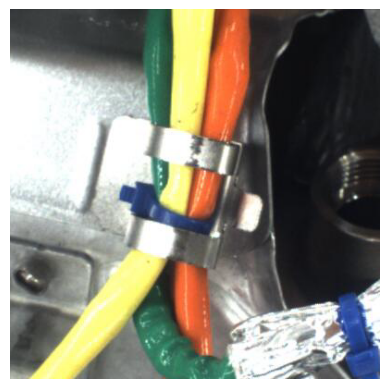

In [4]:
def images_backup(folder_path): 
    target_size = (400, 400)  
    images, filenames = load_images_from_folder(folder_path, target_size)

    return normalize_conv(images), normalize(images)

images_conv, images =images_backup( '/home/jgayraud/Documents/MIC3/BE/engine_wiring/train/good')
plotimage(images[3,:])


## Definition du modèle ( modèle des couches linéaires )

Nous avons dans un premirer temps implémenté un encodeur et un decodeur avec uniquement des couches linéaires. 
Ce modèle n'était pas très efficace car les couches linéaires ne sont pas très adaptées pour le traitement d'image. En effet, il y a des inconvéniants au modèle linéaire :
- elle nécessite la transformation des images qui sont des tableaux 3D en des tableaux 1D : nous perdons la structure d'une image, aucune analyse locale ou analyse des couleurs est possible
- elle ne reconnaît pas bien les formes et ne permet pas de capturer les détails en particulier  
- demande beaucoup de mémoire

In [5]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(400*400*3, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 20)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,400*400*3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## Définition du modèle ( modèle de convolution)

### Encodeur 
Après avoir essayé l'encodeur simple avec des couches linéaires nous sommes passé à un encodeur avec 4 couches de convolutions et une couche linéaire en utlisant arbitrairement la fonction d'activation ReLU.

Les couches de convolutions permettent de glisser un filtre sur l’image et de détecter des motifs, ce sont des couches adaptées au traitement d'image.
Elles permettent d'avoir une meilleure analyse des images en extrayant automatiquement les caractéristiques importantes comme :les bords, les textures,les formes complexes, les relations spatiales entre les pixels

Ensuite on transforme le tenser généré par les couche de convolution en un vecteur pour l'espace latent grâce la fontion flatten() et une couche linéaire.

### Decodeur 
Apres avoir retransformé le vecteur de l'espace latent en tenser, nous sommes également passé a un décoceur utilisant des couches de convolutions et des fonction d'activation ReLU.

In [6]:
class AE_CNN(torch.nn.Module):
    def __init__(self):
        super(AE_CNN, self).__init__()
       
        # --- ENCODEUR CNN ---
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 400x400 → 200x200
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 200x200 → 100x100
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 100x100 → 50x50
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 50x50 → 25x25
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 25 * 25, 20)  # Vecteur latent de taille 20
        )
       
        # --- DÉCODEUR CNN ---
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 256 * 25 * 25),  # Reconversion du vecteur latent
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (256, 25, 25)),  # Reformater en "image" 2D
           
            torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 25x25 → 50x50
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 50x50 → 100x100
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 100x100 → 200x200
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 200x200 → 400x400
            torch.nn.Sigmoid()  # Normalisation entre 0 et 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

Dans le code qui suit, nous vérifions que l'ordinateur possède un gpu pour optimiser la durée des calculs

In [7]:
torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.device("cpu") 
print(device)

cuda


# Définition de certains hyperparamètres

Dans la cellule de code qui suit, nous avons fixé les paramètres suivants:
- La **taille du bash** (32). Le modèle est mis à jour toutes les 32 images.
- **Adam optimizer** : c'est un algorithme d'optimisation qui modifie les poids du modèle dans la direction qui minimise l'erreur de reconstruction. De plus, il prend en compte le nombre de fois que les poids sont modifiés et l'importance du changement (plus un poids est sujet au changement moins on va le modifier pour éviter des fluctuations élevées de la qualité du modèle en fonction de l'image d'entrée).
- La **Learning Rate** (lr = 1e-3) représente la vitesse d'apprentissage. Si c'est trop grand les poids du modèle risquent de trop osciller et si c'est petit l'apprentissage est long. Nous avons utilisé une valeur standard.
- la **Weight Decay** (1e-5) est un paramètre qui ajoute une pénalité sur la taille des poids du modèle pour éviter qu'ils deviennent trop grands. Cela aide à prévenir l'overfitting et rend l'apprentissage plus stable. Nous avons utilisé une valeur standard

Nous avons choisi une première valeur pour ces hyperparamètres en regardant des tutos et en copiant les valeurs. Puis nous avons réévalué la learning rate (0.1 -> 1e-3) car nous avions choisi une valeur trop élevée qui amenait à un surapprentissage du modèle.

# Adaptation des données au modèle

Nous avons aussi créé des tensors grâce à la bibliothèque torch pour pouvoir utiliser nos images dans l'entraînement du modèle

In [9]:
# les to(device) deplace les objets sur le gpu pour faire le training
torch.cuda.empty_cache()
if 'model' in locals():
    del model
if 'optimizer' in locals():
    del optimizer
if 'images_tensor' in locals():
    del images_tensor
if 'dataset' in locals():
    del dataset
if 'loader' in locals():
    del loader


model = AE_CNN().to(device)
BashSize = 32


loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)


images_tensor = torch.tensor(images, dtype=torch.float32).to(device)

images_tensor_conv = torch.tensor(images_conv, dtype=torch.float32).permute(0,3,1,2).to(device)



#dataset = TensorDataset(images_tensor)

loader = torch.utils.data.DataLoader(dataset = images_tensor_conv,
                                     batch_size = BashSize,
                                     shuffle = True)

## Entrainement du modèle 
Nous avons entrainé notre modèle sur 20, 30, 50 et 100 époques pour obtenir des résultats beaucoup plus net à chaque fois qu'on augmente.

Nous avons rencontré un problème de gestion de memoire donc nous avons fait attention à supprimer ce qui ne nous sert plus pour libérer la mémoire à chaque itération (inputs, targets, outputs) et nous avons fait d'autres optimisations.

## Interprétation de notre code

- Nous avons réalisé 100 époques, c'est à dire que chaque image a servit à entrainer le modèle 100 fois (On utilise toutes les images puis on réitère le procécus) 
(`for epoch in range(num_epochs):`)
- On décompose le dataset en batchs composés de 32 images. Et on itère sur chaque batch (`for batch in loader:`)
- On analyse les erreurs de reconstruction du modèle pour le batch. (`loss = loss_function(outputs, targets`) 
- On update la base selon l'aglorithme Adam et les valeurs d'erreurs obtenues. (`loss.backward() optimizer.step() `)
- On stocke La valeur de l'erreur de reconstruction au fil des batchs pour voir son évolution. (`losses.append(loss.item())`)


In [10]:
num_epochs = 100
losses = []
optimizer.zero_grad()
for epoch in range(num_epochs):
    for batch in loader:
        # Séparer les données d'entrée et les cibles (ici, les mêmes images)
        inputs = batch.to(device)
        targets = inputs
        
        # Passer les données dans le modèle

        outputs = model(inputs)
        # Calculer la perte
        loss = loss_function(outputs, targets)
        
        # Rétropropagation et mise à jour des poids

        loss.backward()
        optimizer.step()    
        # Remettre les gradients à zéro
        optimizer.zero_grad()
        

        losses.append(loss.item())
        # supprimer ce qui ne nous sert plus pour libérer la mémoire (probleme de taille)
        del inputs, targets, outputs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Entraînement terminé.")



Epoch [1/100], Loss: 0.6937
Epoch [2/100], Loss: 0.6761
Epoch [3/100], Loss: 0.6256
Epoch [4/100], Loss: 0.6074
Epoch [5/100], Loss: 0.5737
Epoch [6/100], Loss: 0.5496
Epoch [7/100], Loss: 0.5562
Epoch [8/100], Loss: 0.5519
Epoch [9/100], Loss: 0.5488
Epoch [10/100], Loss: 0.5448
Epoch [11/100], Loss: 0.5439
Epoch [12/100], Loss: 0.5422
Epoch [13/100], Loss: 0.5337
Epoch [14/100], Loss: 0.5450
Epoch [15/100], Loss: 0.5482
Epoch [16/100], Loss: 0.5388
Epoch [17/100], Loss: 0.5408
Epoch [18/100], Loss: 0.5252
Epoch [19/100], Loss: 0.5343
Epoch [20/100], Loss: 0.5292
Epoch [21/100], Loss: 0.5186
Epoch [22/100], Loss: 0.5258
Epoch [23/100], Loss: 0.5239
Epoch [24/100], Loss: 0.5123
Epoch [25/100], Loss: 0.5120
Epoch [26/100], Loss: 0.5092
Epoch [27/100], Loss: 0.5163
Epoch [28/100], Loss: 0.5020
Epoch [29/100], Loss: 0.4976
Epoch [30/100], Loss: 0.4961
Epoch [31/100], Loss: 0.4904
Epoch [32/100], Loss: 0.4986
Epoch [33/100], Loss: 0.4890
Epoch [34/100], Loss: 0.4891
Epoch [35/100], Loss: 0

# Enregistrement des poids

In [11]:
torch.save(model.state_dict(),'/home/jgayraud/Documents/MIC3/BE/Detection-d-anomalie/model.pth')

# Chargement du modèle déjà entrainé

In [12]:
loadmodel = AE_CNN().to(device)
loadmodel.load_state_dict(torch.load('/home/jgayraud/Documents/MIC3/BE/Detection-d-anomalie/model.pth'))

<All keys matched successfully>

# Evolution de l'erreur de reconstruction

Durant l'entraînement, nous avons enregistré les erreurs de reconstruction pour chaque batch.
Nous avons représenté ci-dessous l'évolution de l'erreur de reconstruction au fil des batchs. Nous remarquons que la plus forte pente est obtenue entre le batch 0 et le batch 100, en effet, l'ereur a diminué de 0.75 à 0.55 avant la fin de la période 13. Cela représente plus de la moitié de la diminution de l'erreur obtenue à la fin de l'entraînement.

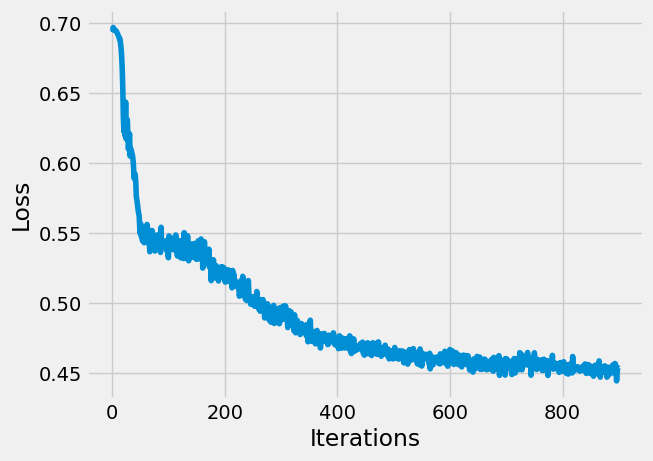

In [13]:
losses_np = [loss for loss in losses]

# Définir le style du graphique
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Tracer les 100 dernières valeurs de perte
plt.plot(losses_np[:])

# Afficher le graphique
plt.show()

# Visualisation

Afin de tester nos modèles nous testons d'afficher l'image originale et son image reconstruite pour vérifier le bon fonctionnement du modèle.

Il y a 2 codes différents pour nos deux types de modèles car le format d'entrée n'est pas le même (vecteur pour l'un et tenseur pour l'autre)

## Code pour afficher l'image originale et l'image reconstruite par le modèle linéaire

In [21]:
def _():
        # Convertir l'image en tenseur
    number = 3

    image_tensor = torch.tensor(images[number, :], dtype=torch.float32).view(1, -1)

    # Passer l'image à travers le modèle pour obtenir la reconstruction
    model.eval()  # Passer le modèle en mode évaluation
    with torch.no_grad():
        reconstructed_image = model(image_tensor)

    # Remettre en forme et afficher l'image originale et la reconstruction
    original_image = images[number, :].reshape(400, 400, 3)
    reconstructed_image = reconstructed_image.view(400, 400, 3).numpy()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Image Originale')
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title('Image Reconstruite')
    plt.imshow(reconstructed_image)

    plt.show()

## Code pour afficher l'image originale et l'image reconstruite par le modèle de convolution

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])
(400, 400, 3)


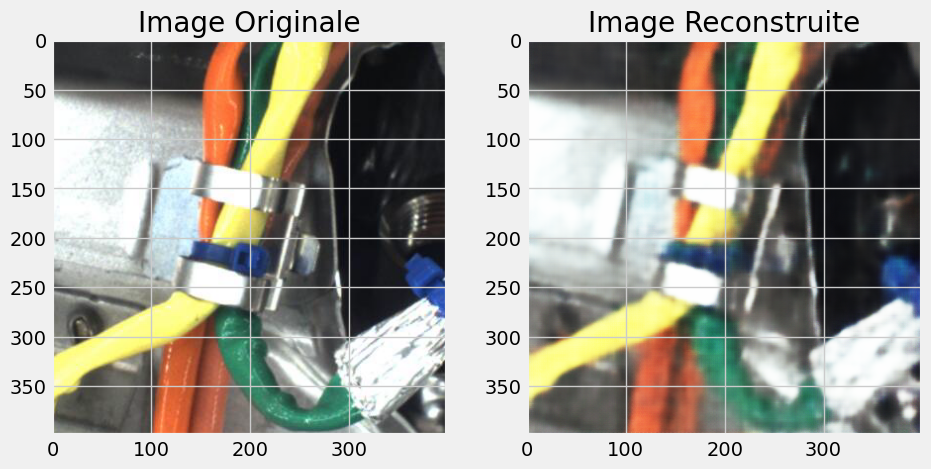

In [24]:
def test_modele(number,images_conv):
    # Convertir l'image en tenseur
    image_tensor = torch.tensor(images_conv[number, :,:,:], dtype=torch.float32).to(device).permute(2,0,1).reshape(1,3,400,400)
    print(image_tensor.shape)
    # Passer l'image à travers le modèle pour obtenir la reconstruction
    loadmodel.eval()  # Passer le modèle en mode évaluation
    with torch.no_grad():
        reconstructed_image = loadmodel(image_tensor)

    # Remettre en forme et afficher l'image originale et la reconstruction
    original_image = images_conv[number, :,:,:]
    print(reconstructed_image.shape)
    reconstructed_image = reconstructed_image.cpu().squeeze(0).permute(1,2,0).numpy()

    print(reconstructed_image.shape)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Image Originale')
    plt.imshow(original_image)

    plt.subplot(1, 2, 2)
    plt.title('Image Reconstruite')
    plt.imshow(reconstructed_image)

    plt.show()

test_modele(20,images_conv= images_conv)



# Reconstruction d'images de test avec et sans anomalies  

### Récuperation des images de test normales 

In [27]:
test_images_conv, test_images =images_backup(  '/home/jgayraud/Documents/MIC3/BE/engine_wiring/test/good')


### Récuperation des images de test anormales 

In [28]:
abnormal_images_conv, abnormal_images =images_backup('/home/jgayraud/Documents/MIC3/BE/engine_wiring/test/cardboard')



## Test sur les donées normales et anormales

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])
(400, 400, 3)


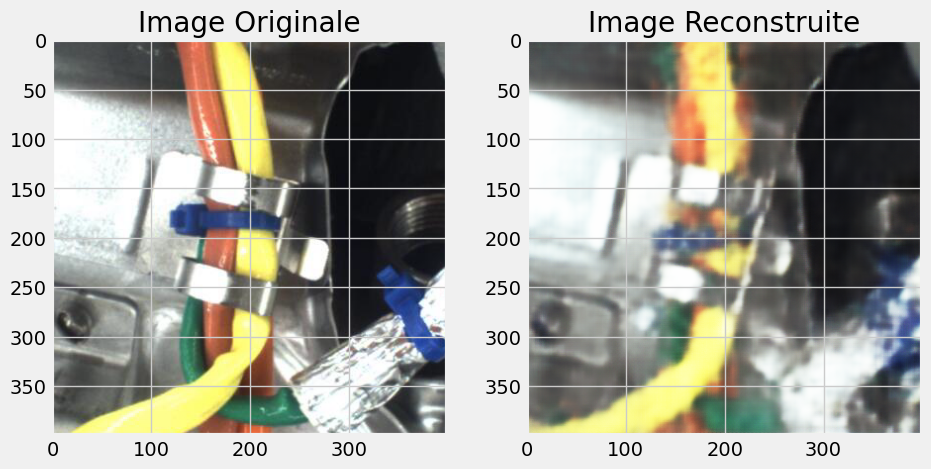

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])
(400, 400, 3)


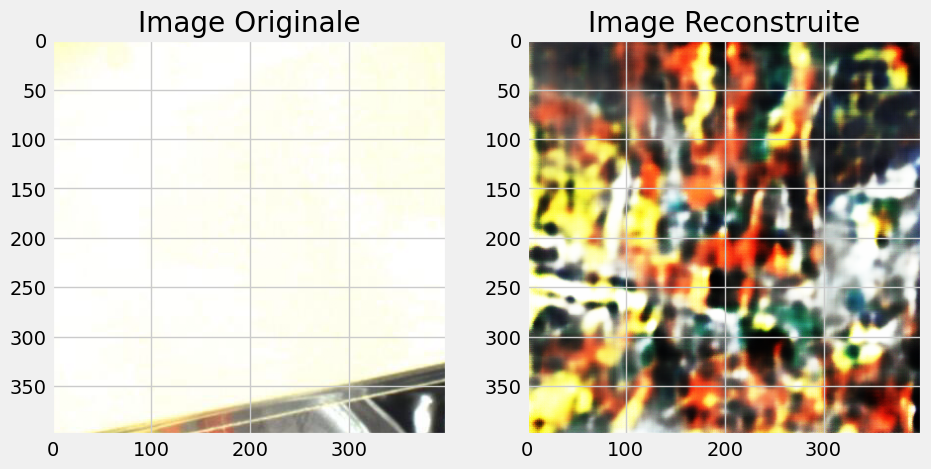

In [29]:

test_modele(20,images_conv= test_images_conv)
test_modele(4,abnormal_images_conv)